# Generalizability Test Using Real World Data - Language Classification
#### By: Bowen Zhang


## Overview

This was a continuation of the previous notebook: `Prototyping_CNN_Models`. Please refer there for the context of this project. In this notebook we are testing the models we have prototyped previously on real world data. This will see how the models perform on data that is completely outside of their ecosystem and has various levels of noise. This is not meant to be a holistic or scientific test, just a way to gauge and poke at the models we previously ran and try to decided on which one performs best in different circumstances.

To test our model's robustness with real world data, I have scraped together audio clips from youtube of podcasts, language lessons, or even vlogs. Each language has two speakers (one male and one female) and each of their audio clips are around 15 minutes long. That is ~200-250 samples each. So there are ~400-500 samples per language, for a total of ~2000-2500 test samples with completely new data. I chose youtube, because it has very conversational speech. This can help us test the generalizability of the model, and also where its weaknesses are.

**NOTE:** All the code below was ran using a PC with the specs below. GPU used was a GTX1080. Your experiences may vary if you have different specs.

In [15]:
# get PC specs
%watermark -v -m -p numpy,pandas,matplotlib,sklearn,librosa,torch

CPython 3.8.5
IPython 7.16.1

numpy 1.19.1
pandas 1.0.5
matplotlib 3.2.2
sklearn 0.23.2
librosa 0.6.3
torch 1.6.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores  : 8
interpreter: 64bit


## Table of Contents

1. [Set Up The Environment](#setup) <br>
2. [Convert into Mel Spectrograms](#transform) <br>
    2.1 [Function](#transform) <br>
    2.2 [Conversion](#convert)
3. [Testing Early Stopped Models](#earlystopped) <br>
    3.1 [First Model](#firststop) <br>
    3.2 [Second Model](#secondstop) <br>
    3.3 [Third Model](#thirdstop) <br>
4. [Testing Models without Early Stopping](#nostop) <br>
    4.1 [Test Results](#testresults) <br>
    4.2 [Confusion Matrix](#cmresults) <br>
5. [Conclusion](#conclusion)

<a id="setup"></a>
## Setup Environment

In [1]:
import librosa                    
import librosa.display
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import torch
import torchvision
import torchvision.transforms as tf
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import torch.nn as nn
import torch.nn.functional as F

<a id="transform"></a>
## Convert into Mel Spectrograms
Here we will define a function that will take the downloaded audio clips, which we have stored in the `external_test` folder, and convert it into a series of melspectrograms. It will then output them into a folder separated by each individual class (language) so we can use them as a new test set.

In [2]:
## Converting the audio clips into spectrograms
# taking the function we created to convert our train and test wav files into melspectrograms and changing it a little for our purpose here

def create_mel (fold, MAX=250, n_fft = 2048, hop_length = 512, n_mels = 64, f_min = 20, f_max = 8000, sample_rate = 16000):
    '''
    Function meant to chop long audio files into small samples and convert them into melspectrograms
    The output of files will be saved into a folder with just the melspectrograms
    
    fold = path of the input folder with the wav files
    MAX = limit the number of melspectrograms to convert for each file
    '''
    
    # creates subdirectories for the output of melspectrogram images (train/test split)
    # NOTE: you will need to manually add more for additional languages you choose to include
    save_path = f"external_test/{fold.replace('_wav', '')}"
    
    # create the path for the spectrograms if it doesn't exist already
    if os.path.isdir(save_path):
        pass
    else:
        os.makedirs(save_path)
    
    # convert wav to melspectrograms and saves the image  
    for audio_file in os.listdir(path=fold):
         
        print(f"Creating Melspectrograms for {audio_file}...")
        
        clip, sample_rate = librosa.load(path=f'{fold}/{audio_file}', sr=sample_rate)
        duration = len(clip)
                
        counter = 0   # counter to track number of conversions
        start = 0     # starting sample window
        end = 60000   # end sample window
        while True:
            try:
                clip_window = clip[start:end]
                
                # initialize our plot for the melspectrogram    
                fig = plt.figure(figsize=[0.75,0.75])
                ax = fig.add_subplot(111)
                ax.axes.get_xaxis().set_visible(False)
                ax.axes.get_yaxis().set_visible(False)
                ax.set_frame_on(False)

                # create the melspectrogram as a plot
                mel_spec = librosa.feature.melspectrogram(clip_window, n_fft=n_fft, hop_length=hop_length, n_mels = n_mels,
                                                  sr=sample_rate, power=1.0, fmin=f_min, fmax=f_max)
                librosa.display.specshow(librosa.amplitude_to_db(mel_spec, ref=np.max), fmax=f_max, sr=sample_rate)

                # extract the speaker from filename and rename with autoincrement key
                new_name = audio_file.replace(".wav", f'-{counter}.png')
                filename  = f'{save_path}/{new_name}'

                # save the output image
                plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
                plt.close('all')

                counter+=1
                start+=60000
                end+=60000
                
                if counter >= MAX:
                    print("--Done. Reached max samples")
                    break

            except ValueError:
                print("--Done. End of File")
                break


In [51]:
# change our working directory to the external test data folder and list the language wav folders
os.chdir("external_test_data")
folders = os.listdir() 
folders

['English_wav', 'French_wav', 'German_wav', 'Italian_wav', 'Spanish_wav']

<a id="convert"></a>
Now, let's create the spectrograms from our randomly scraped audio data from YouTube. We can then use these as test data to see how our model does with data from the real world outside of our data set. We will just loop over each language folder and run our previously defined function.

In [53]:
# run the for loop for each langauge
for fold in folders:
    create_mel(fold, MAX=200)

Creating Melspectrograms for english-man.wav...
--Done. Reached max samples
Creating Melspectrograms for english-woman.wav...
--Done. Reached max samples
Creating Melspectrograms for french-man.wav...
--Done. Reached max samples
Creating Melspectrograms for french-woman.wav...
--Done. Reached max samples
Creating Melspectrograms for german-man.wav...
--Done. Reached max samples
Creating Melspectrograms for german-woman.wav...
--Done. Reached max samples
Creating Melspectrograms for italian-man.wav...
--Done. Reached max samples
Creating Melspectrograms for italian-woman.wav...
--Done. Reached max samples
Creating Melspectrograms for spanish-man.wav...
--Done. Reached max samples
Creating Melspectrograms for spanish-woman.wav...
--Done. Reached max samples


<a id="earlystopped"></a>
## Testing Early Stopped Models
Now that we have created our test spectrograms, let's load in our models and functions to test with. Let's move back to the original working directory as well. We are first going to load in the 3 early stopped models from the previous notebook. 

In [67]:
# change working directory
os.chdir("Desktop/Audio-Language-Classifier")

In [3]:
# import the helper functions we need
# import the model we will be using
import helpers
from helpers import generate_cm, get_device, to_device, DeviceDataLoader, evaluate
from model import CNN_model_3
device = get_device()

Let's load in the best top saved models from our prototyping notebook. These models are the early stopped versions. We will try these models first because we want to try our model with the most regularization since we are trying this on completely new data.

In [12]:
# load in our previous model state / weights
CNN_model_base = CNN_model_3(opt_fun=torch.optim.Adam, lr=0.001)
CNN_model_base.load_state_dict(torch.load("CNN_model_base.pt"))
CNN_model_base.eval()

CNN_model_2 = CNN_model_3(opt_fun=torch.optim.Adam, lr=0.001)
CNN_model_2.load_state_dict(torch.load("CNN_model_opt2.pt"))
CNN_model_2.eval()

CNN_model_opt = CNN_model_3(opt_fun=torch.optim.Adam, lr=0.0001, weight_decay=0.0001)
CNN_model_opt.load_state_dict(torch.load("CNN_model_opt3.pt"))
CNN_model_opt.eval()
device

device(type='cuda')

Now that we have our models, let's load in the new external test data and make sure they have the right classes.

In [4]:
# import our data set and convert to tensors
transformations = tf.Compose([tf.Resize([64,64]), tf.ToTensor()]) 
extestset = ImageFolder('external_test_data/external_test', transform=transformations)

# check
classes = extestset.classes
print(classes)

['English', 'French', 'German', 'Italian', 'Spanish']


Let's load our model and test dataloader for the GPU for faster evaluation times.

In [6]:
# set up our test dataloader
test_dl = DataLoader(extestset, 128)

Performing a spot check to make sure our models loaded have the same weights as when we saved them. They should return the same accuracy scores as the other notebook.

In [14]:
# making sure our models are the same as before:
testset = ImageFolder('data/test', transform=transformations)
old_test_dl = DataLoader(testset, 128)

In [15]:
# move to GPU
CNN_model_base.cuda()
CNN_model_2.cuda()
CNN_model_opt.cuda()
test_dl = DeviceDataLoader(test_dl, device)
old_test_dl = DeviceDataLoader(old_test_dl, device)

In [137]:
_, test_score = evaluate(CNN_model_base, dataloader=old_test_dl, calc_loss=False)
print(f"Test Score: {test_score:.2f}%")

_, test_score = evaluate(CNN_model_2, dataloader=old_test_dl, calc_loss=False)
print(f"Test Score: {test_score:.2f}%")

_, test_score = evaluate(CNN_model_opt, dataloader=old_test_dl, calc_loss=False)
print(f"Test Score: {test_score:.2f}%")

Test Score: 78.84%
Test Score: 78.31%
Test Score: 83.96%


The test scores are exactly the same as during prototyping. These are the correct models.

<a id="firststop"></a>
#### First Model (CNN_model_base) - Early Stopped
Testing our first model. This was the baseline model that had early stopping performed at epoch 7. 

In [95]:
# calculate accuracy
_, test_score = evaluate(CNN_model_base, dataloader=test_dl, calc_loss=False)
print(f"Test Score: {test_score:.2f}%")

Test Score: 42.65%


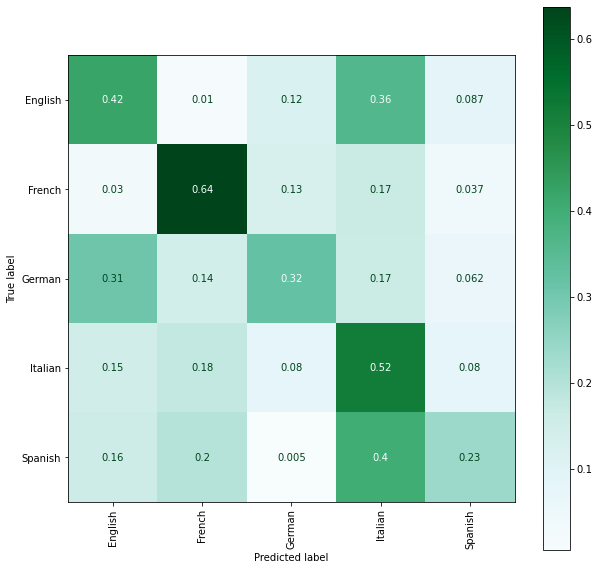

In [131]:
# Evaluate with the confusion matrix
generate_cm(CNN_model_base, test_dl, classes)

Seems like the generalizability of the model is kind of poor. Again, it should be noted that there are only two speakers, so if the audio file is bad then most of the data will be poor for 50% of that classes' data. However, it seems like the spanish data is getting confused with the italian data, but not vice versa. We saw this in the original dataset too, as Spanish was the worst performing language and would often get confused with Italian. In this case, it could be due to the fact that the spanish audio file for male was actually EXTREMELY poor. This could suggest that pre-processing and audio quality really matters, and may amplify any weaknesses our model has. 

Also, the English data is also being confused with the Italian data. That is really interesting, as half our sample (the female speaker) has a very prominent African-American dialect. Our training data had some speakers with accents, but never slang or dialects. This may be one of the reasons it's throwing the model off for English, when it performed very well in our original test data. Furthermore, Italian does have quite a high rate of error for all the other languages as well. This could be due to the fact that all these languages are latin root based, so Italian being root language could be confusing for the model to differentiate other languages. That is why we see such a high accuracy with Italian, and other languages seems to fall under Italian as well, but not vice versa. 

Another thing to consider is the pitch/voice bias. We can also look at how each individual audio file / person holds up against the model. This way we might be able to isolate where our model is being confused. But before we do that, let's test our second model's generalizability (which I assume will be better because it had regularization). 

<a id="secondstop"></a>
#### Second Model (CNN_model_2) - Early Stopped
Now let's try out second model with weight decay at 0.0001 and early stopped.

In [128]:
# calculate accuracy
_, test_score = evaluate(CNN_model_2, dataloader=test_dl, calc_loss=False)
print(f"Test Score: {test_score:.2f}%")

Test Score: 38.95%


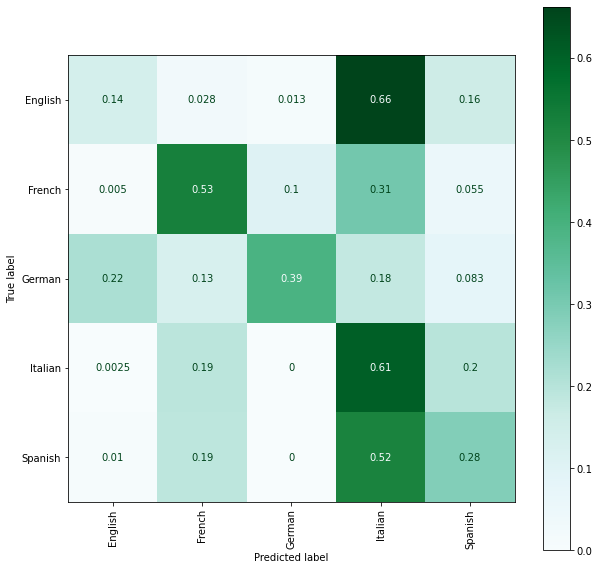

In [130]:
# Evaluate with the confusion matrix
generate_cm(CNN_model_2, test_dl, classes)

The English and Spanish are being classified as Italian very strongly in this model. We are still seeing the same issues, however just more prominent here.

<a id="thirdstop"></a>
#### Third Model (CNN_model_opt) - Early Stopped
Finally our third model with weight decay at 0.0001 and learning rate at 0.0001 and early stopped at 17 epochs.

In [105]:
# calculate accuracy
_, test_score = evaluate(CNN_model_opt, dataloader=test_dl, calc_loss=False)
print(f"Test Score: {test_score:.2f}%")

Test Score: 36.35%


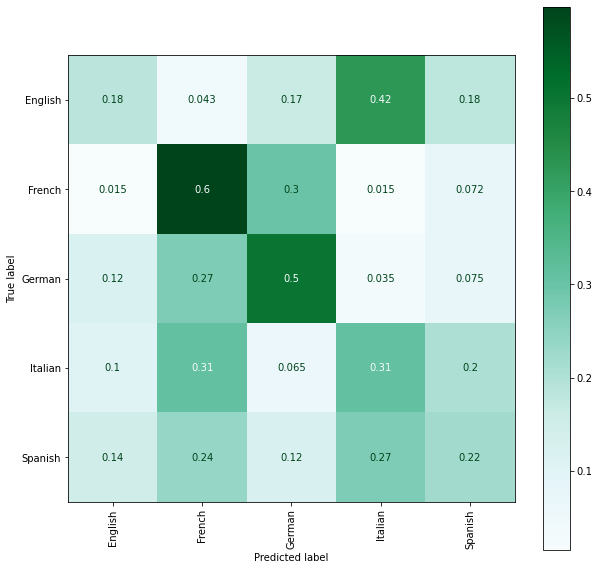

In [132]:
# Evaluate with the confusion matrix
generate_cm(CNN_model_opt, test_dl, classes)

The model actually seems to perform worse than the first one. This is quite interesting, because in our original prototyping, this model definitely has the most promise. Perhaps we should have included data that was a bit more clean and uniform, however this is a great robustness test for our models who have only been trained on just 1 dataset with a very limited amount of data. For curiousity sake, let's see how our non-early stopped models will perform.

<a id="nostop"></a>
## Looking at the Models without Early Stopping
Since our early stopped models did not perform so well, let's also test the other models we have saved during our hyperparameter tuning. Let's try the models without the early stopping and see how they perform. Now, we are doing the opposite of our ground-up approach when prototyping the models. Now we are going from our most tuned and complex models to the least tuned and back towards the baseline versions. So here we will have our baseline model with just the original parameters and no weight decay or gradient clipping, second model with weight decay = 0.0001 and gradient clipping = 0.1, and our third model with the same parameters as the second model except a lower learning rate of 0.0001.

In [7]:
### Model states without early stopping ###

# this is the complete baseline model with 20 epochs
experiment_model_1 = CNN_model_3(opt_fun=torch.optim.Adam, lr=0.001)
experiment_model_1.load_state_dict(torch.load("trained_model_3_state.pt"))
experiment_model_1.eval()

# second attempt with weight decay
experiment_model_2 = CNN_model_3(opt_fun=torch.optim.Adam, lr=0.001, weight_decay=0.0001)
experiment_model_2.load_state_dict(torch.load("trained_model_3_opt2_state.pt"))
experiment_model_2.eval()

# third attempt 
experiment_model_3 = CNN_model_3(opt_fun=torch.optim.Adam, lr=0.0001, weight_decay=0.0001)
experiment_model_3.load_state_dict(torch.load("trained_model_3_opt3_state.pt"))
experiment_model_3.eval()
device

device(type='cuda')

In [8]:
# move models to the GPU
experiment_model_1.cuda()
experiment_model_2.cuda()
experiment_model_3.cuda()
print('moved to GPU')

moved to GPU


<a id="testresults"></a>
#### Test Results
Let's see how each of the model performs and score them all at once.

In [110]:
_, test_score = evaluate(experiment_model_1, dataloader=test_dl, calc_loss=False)
print(f"Experiment Model 1 - Test Score: {test_score:.2f}%")

_, test_score = evaluate(experiment_model_2, dataloader=test_dl, calc_loss=False)
print(f"Experiment Model2 - Test Score: {test_score:.2f}%")

_, test_score = evaluate(experiment_model_3, dataloader=test_dl, calc_loss=False)
print(f"Experiment Model 3 - Test Score: {test_score:.2f}%")

Experiment Model 1 - Test Score: 45.75%
Experiment Model2 - Test Score: 45.55%
Experiment Model 3 - Test Score: 35.80%


Surprisingly, the baseline and the second model performed quite well and much better than the early stopepd versions.

<a id="cmresults"></a>
#### Confusion Matrix
Let's see the confusion matrix for each of these models respectively.

Model 1 Confusion Matrix


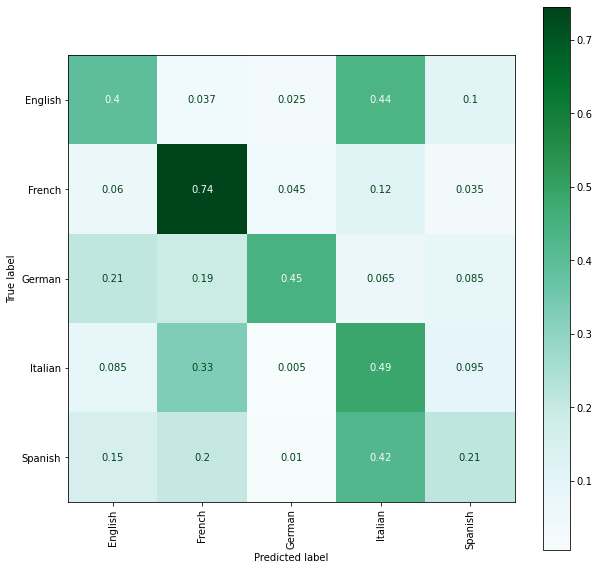

Model 2 Confusion Matrix


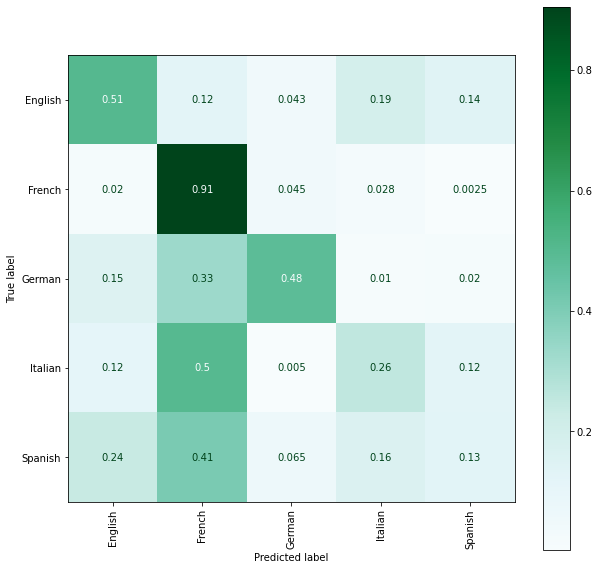

Model 3 Confusion Matrix


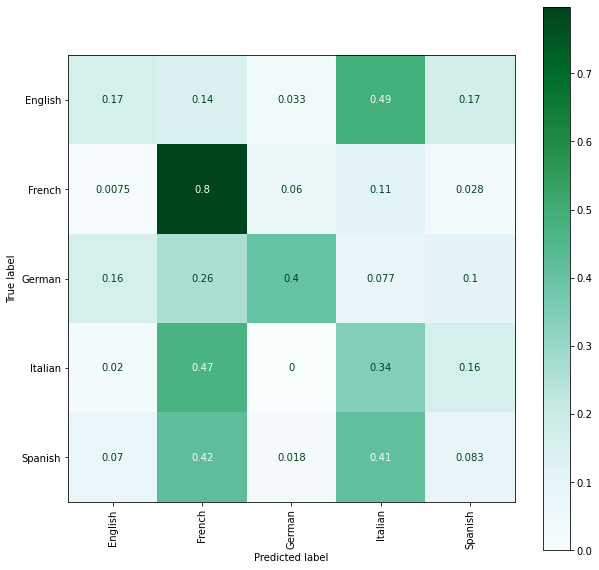

In [9]:
# confusion matrix for each model
i=1
for model in [experiment_model_1, experiment_model_2, experiment_model_3]:
    print(f"Model {i} Confusion Matrix")
    generate_cm(model, test_dl, classes)
    i += 1

<a id="conclusion"></a>
## Conclusion:
It seems like models trained with higher learning rates perform a lot better than models with lower learning rates in terms of generalizability. We do still see the same issues occuring with Spanish, English, and Italian as in the previous models. Our baseline model without early stopping or any weight decay / gradient clipping is performing on par with our hyper-tuned models. Our model still cannot seem to get beyond 50% accuracy with completely new data (with different preprocessing, noise, speech patterns). For both these cases, it seems like the **baseline models**, whether early stopping or not, seem to perform much better as well. This is interesting, because we introduced weight decay to help regularize the model and avoid overfitting. Perhaps the model was not as complex as we thought it was, and didn't really have that issue. So, I think from this performance, and from our previous performance, the best model so far is actually our `baseline model_3` with no gradient clipping or weight decay. The early stopped version of that model performed well on the general dataset, but poorly on the test data. So overall, our baseline model was actually fine to begin with all along. Nevertheless, this was a great experiment to see different tuned variations of a neural network model, and how it performs on this data. 

Next steps could definitely be to introduce more external data in the training set and try to train our model again, or use fewer classes as it seems getting rid of Italian may improve our accuracy greatly. To test the more subtle nuances, we can try to pass in individual voice clips that we can listen to and evaluate how the model will respond. In this way, we can learn more about the model than doing confusion matrixes or classification tests. To do so, I will be creating a demo application that will allow users to upload voice clips to pass through the model and return an output. This will allow us to 1) create a cool data product, and 2) unit test the model with individual clips which can allow us to probe the model a bit more and better understand the nuances of it.